In [32]:
# Load packages

import os
from os import path
from typing import Optional
import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm

# Deep Learning
import torch
import torch.nn            as nn
import torch.nn.functional as F
import torchinfo
import cv2 as cv

import matplotlib.pyplot as plt

In [33]:
# Parameters

MY_NAME_IS = 'Nitzan'

TRAIN_PARTS = [1]
TEST_PARTS = [5]

DOWN_FPS = 10
FRAME_SCALE = 20
GRAYCOLOR = False

BATCH_SIZE = 3
EPOCH_NUM = 1

################################################################################################

DATA_FOLDER_DICT = {
    'Victor': ['E:\DeepFakeDetection\dfdc_train_all','E:\DeepFakeDetection\smalldata'],
    'Nitzan': ['D:\dfdc','D:\dfdc_small6'],
    'Netanel':['F:\input','F:\input']}
BIG_DATA_FOLDER = DATA_FOLDER_DICT[MY_NAME_IS][0]
SMALL_DATA_FOLDER = DATA_FOLDER_DICT[MY_NAME_IS][1]

TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The chosen device: {TORCH_DEVICE}')

SMALLFILE_EXT = 'tns'

The chosen device: cuda


In [34]:
# Load and concat all JSON files

meta_df = pd.DataFrame()
metadata_glob = glob.iglob('**/metadata.json', recursive=True, root_dir=BIG_DATA_FOLDER)
ii = 0
for metadata in metadata_glob:
    metadata_path = path.join(BIG_DATA_FOLDER, metadata)
    dir_path = os.path.dirname(os.path.realpath(metadata_path))
    part_df = pd.read_json(metadata_path).T
    part_df['part'] = ii
    part_df['bigdata_path'] = dir_path
    part_df['smalldata_path'] = f"{SMALL_DATA_FOLDER}\{ii}"
    #part_df['filename'] = part_df.index
    meta_df = pd.concat([meta_df, part_df])
    ii += 1

display(meta_df)

,label,split,original,part,bigdata_path,smalldata_path
owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small6\0
vpmyeepbep.mp4,REAL,train,NaN,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small6\0
fzvpbrzssi.mp4,REAL,train,NaN,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small6\0
htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small6\0
fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4,0,D:\dfdc\dfdc_train_part_0,D:\dfdc_small6\0
...,...,...,...,...,...,...
ltiekbqamw.mp4,FAKE,train,icffpvvtnu.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small6\49
qxkhbvpomm.mp4,FAKE,train,icffpvvtnu.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small6\49
yxgljheoyy.mp4,FAKE,train,rzytdiivhu.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small6\49
wadgdooqpl.mp4,FAKE,train,mhpavogfxb.mp4,49,D:\dfdc\dfdc_train_part_9,D:\dfdc_small6\49


In [35]:
# Split Data, Take part of data

metadata_train_df = meta_df[meta_df['part'].isin(TRAIN_PARTS)].copy()
metadata_test_df = meta_df[meta_df['part'].isin(TEST_PARTS)].copy()
metadata_test_df['split'] = 'test'
metadata_df = pd.concat((metadata_train_df,metadata_test_df))
display(metadata_df)

,label,split,original,part,bigdata_path,smalldata_path
zumqqvixhu.mp4,FAKE,train,hntguogkqd.mp4,1,D:\dfdc\dfdc_train_part_1,D:\dfdc_small6\1
utdlsqfykm.mp4,FAKE,train,nswtvttxre.mp4,1,D:\dfdc\dfdc_train_part_1,D:\dfdc_small6\1
mdfndlljvt.mp4,FAKE,train,ptkcmwnfjv.mp4,1,D:\dfdc\dfdc_train_part_1,D:\dfdc_small6\1
maktypgsfl.mp4,FAKE,train,objgwnmscm.mp4,1,D:\dfdc\dfdc_train_part_1,D:\dfdc_small6\1
pleqihjpif.mp4,FAKE,train,xrhqtmxlvx.mp4,1,D:\dfdc\dfdc_train_part_1,D:\dfdc_small6\1
...,...,...,...,...,...,...
vlrkfbqajs.mp4,REAL,test,NaN,5,D:\dfdc\dfdc_train_part_13,D:\dfdc_small6\5
mdampijxqe.mp4,REAL,test,NaN,5,D:\dfdc\dfdc_train_part_13,D:\dfdc_small6\5
plboestduy.mp4,REAL,test,NaN,5,D:\dfdc\dfdc_train_part_13,D:\dfdc_small6\5
radyyavwaa.mp4,FAKE,test,galckcdeka.mp4,5,D:\dfdc\dfdc_train_part_13,D:\dfdc_small6\5


In [36]:

# New preprocess function. Performs:
# - downscales fps to the given value, 
# - resizes to the given width (preserving aspect ratio)
# - converts to tensor

def preprocess_video(filepath: str, output_fps: int, resize_height: int, crop_size: int):
  cap = cv.VideoCapture(filepath)
  fps = cap.get(cv.CAP_PROP_FPS)
  frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
  fps_step = round(fps / output_fps)

  width: int = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
  height: int = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
  aspect_ratio = width / height
  if (height > width):
    return None

  if not cap.isOpened():
    raise Exception("Error opening video file")
  
  new_width = int(crop_size * aspect_ratio)
  new_height = crop_size
  new_frame_count = frame_count // fps_step

  video = torch.empty((new_frame_count, crop_size, crop_size, 3), dtype=torch.uint8, requires_grad=False)

  for index in range(new_frame_count * fps_step):
    ok, frame = cap.read()
    if not ok:
      print(index, frame_count, new_frame_count*fps_step)
      raise Exception('Error reading frame')

    if index % fps_step != 0:
      continue
    scaled_index = index // fps_step

    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

    # Resize frame, video is in HWC format
    frame = cv.resize(frame, (new_height, new_width), interpolation=cv.INTER_AREA)

    # Center crop frame
    x = (new_width - crop_size) // 2
    y = (new_height - crop_size) // 2
    frame = frame[x:x+crop_size, y:y+crop_size, :] 

    video[scaled_index] = torch.tensor(frame, dtype=torch.uint8, requires_grad=False)

  cap.release()
  return video
  

In [37]:
start_file_index = 2740
file_count = metadata_df.shape[0]

output_fps = 10
resize_width = 128
crop_size = 112

print(cv.getNumThreads())
# cv.setNumThreads(1)

pbar = tqdm(
  metadata_df[start_file_index:].iterrows(), 
  total=file_count-start_file_index, 
  desc="Preprocessing videos"
  )

for file_name, row in pbar:
  try:
    original_file_path = path.join(row['bigdata_path'], file_name)
    base_name, _ = path.splitext(file_name)
    target_file_path = path.join(row['smalldata_path'], f"{base_name}.{SMALLFILE_EXT}")
    
    video = preprocess_video(original_file_path, output_fps, resize_width, crop_size)
    if video is None:
      continue
    # print(video)
    # print(f'video shape: {video.shape}, dtype: {video.dtype}, size in memory: {video.element_size() * video.nelement() / (1024**2):.2f}mb')

    output_dir = row['smalldata_path']
    if not path.exists(output_dir):
      os.makedirs(output_dir)
    torch.save(video, target_file_path)
  except Exception as e:
    print(f"Error: {e}")
    continue


16


Preprocessing videos:   0%|          | 0/2653 [00:00<?, ?it/s]

548 0 5
video shape: torch.Size([100, 112, 112, 3]), dtype: torch.uint8, size in memory: 3.59mb
553 1 5
video shape: torch.Size([100, 112, 112, 3]), dtype: torch.uint8, size in memory: 3.59mb
566 2 5
video shape: torch.Size([100, 112, 112, 3]), dtype: torch.uint8, size in memory: 3.59mb
585 3 5
video shape: torch.Size([100, 112, 112, 3]), dtype: torch.uint8, size in memory: 3.59mb
846 4 5
video shape: torch.Size([100, 112, 112, 3]), dtype: torch.uint8, size in memory: 3.59mb


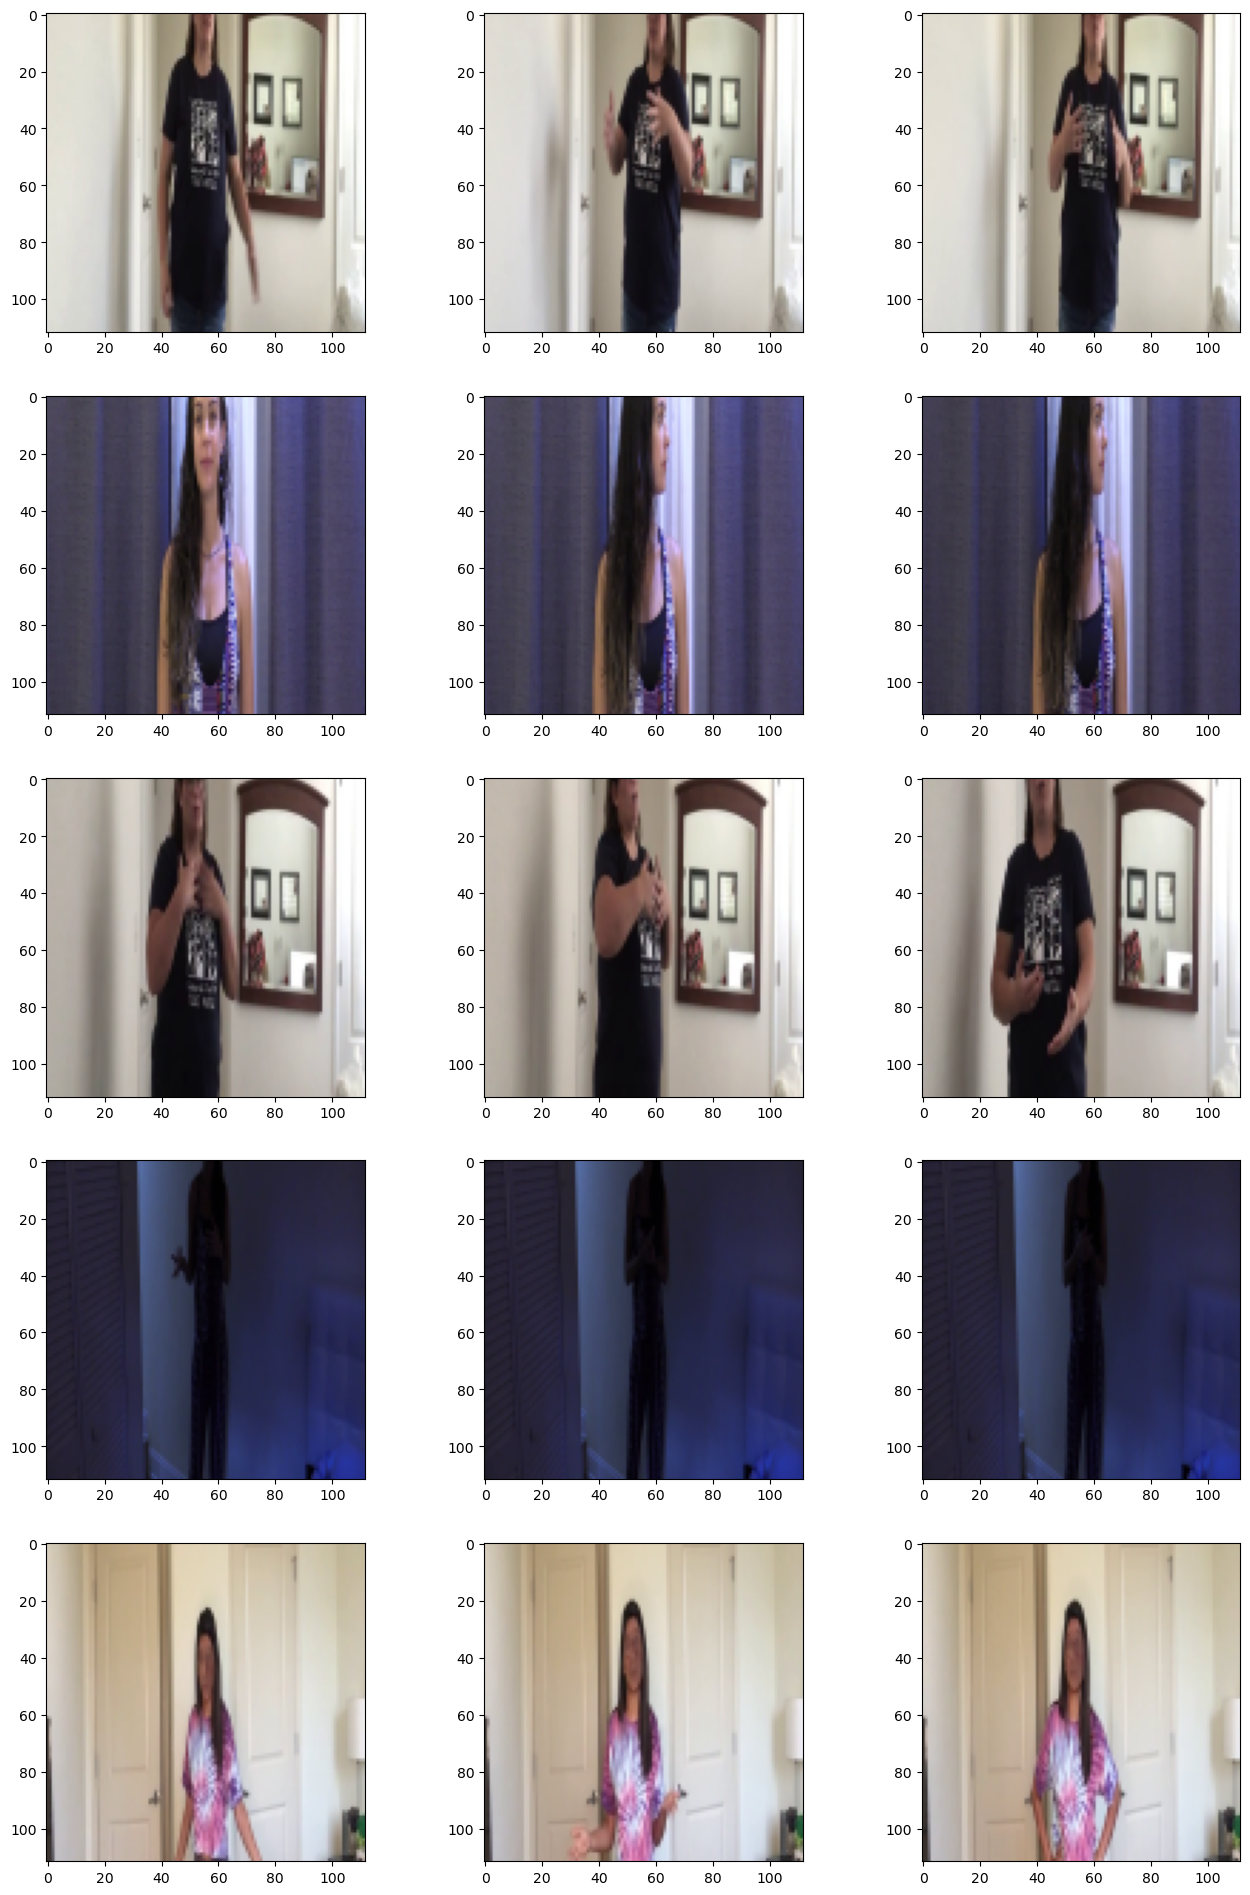

In [38]:
import random

# Sample processed videos

file_glob = glob.iglob(f'**/*.{SMALLFILE_EXT}', recursive=True, root_dir=SMALL_DATA_FOLDER)

fig = plt.figure(figsize=(16, 24))

num_rows = 5
num_cols = 3

random_indices = [random.randint(0, 1_000) for _ in range(num_rows)]
random_indices.sort()

for i, file_path in zip(range(1_000), file_glob):
  if i not in random_indices:
    continue
  j = random_indices.index(i)
  print(i, j, num_rows)

  full_path = path.join(SMALL_DATA_FOLDER, file_path)
  video = torch.load(full_path)
  print(f'video shape: {video.shape}, dtype: {video.dtype}, size in memory: {video.element_size() * video.nelement() / (1024**2):.2f}mb')

  fig.add_subplot(num_rows, num_cols, num_cols*j + 1)
  plt.imshow(video[0])
  fig.add_subplot(num_rows, num_cols, num_cols*j + 2)
  plt.imshow(video[50])
  fig.add_subplot(num_rows, num_cols, num_cols*j + 3)
  plt.imshow(video[-1])
